# Optimal Location to Open a Restaurant in Toronto


# 1. Problem Definition and Background
A client seeks advice as to where to open a Persian restaurant in Toronto to have an optimal return on investment and future growth prospects. This project is aimed to enable the client to make an informed decision about this business venture by locating the optimal neighborhood(s) for such business operations. The following factors seem to be the most effective factors in determining the right neighborhood:
Competition: Existence of a multitude of Persian restaurant in a neighborhood most likely will act as a barrier to entry for new entrepreneurs.
Density of the Persian community in the neighborhood: It is reasonable to expect more sales and revenue in neighborhoods with a denser Persian community.
Spending power: Generally, the more money and buying power people have, the more they are likely to spend money on restaurants and the like.
Potential stakeholders/audience of this project who will benefit from the outcomes are entrepreneurs seeking to find an optimal neighborhood to open a Persian restaurant or intending to expand their franchise to other locations.

# 2. Data Wrangling
For information on the abovementioned factors, we use the census data available on Toronto's Open Data Portal, and after cleaning the data, we store them in the following files for easier usage in the future:
negighbourhood_population.csv
persian_population.csv
income_avg.cs

In [2]:
# importing the necessary libraries for data wrangling
import pandas as pd
import numpy as np
import json
from geopy.geocoders import Nominatim
import folium
import requests
from pandas.io.json import json_normalize
import wget
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
from sklearn.cluster import KMeans

In [3]:
df_pop = pd.read_csv('negighbourhood_population.csv')

In [4]:
df_pop.head()

,Unnamed: 0,Neighbourhood,Total Population
0,0,Agincourt North,"29,113"
1,1,Agincourt South-Malvern West,"23,757"
2,2,Alderwood,"12,054"
3,3,Annex,"30,526"
4,4,Banbury-Don Mills,"27,695"


In [5]:
df_per = pd.read_csv('persian_population.csv')

In [6]:
df_per.head()

,Unnamed: 0,Neighbourhood,Persian Population
0,0,Agincourt North,100
1,1,Agincourt South-Malvern West,175
2,2,Alderwood,15
3,3,Annex,365
4,4,Banbury-Don Mills,895


In [7]:
df_income = pd.read_csv('income_avg.csv')

In [8]:
df_income.head()

,Unnamed: 0,Neighbourhood,Average After-tax income
0,0,Agincourt North,"26,955"
1,1,Agincourt South-Malvern West,"27,928"
2,2,Alderwood,"39,159"
3,3,Annex,"80,138"
4,4,Banbury-Don Mills,"51,874"


In [9]:
# downloading the geographical coordinates
url = 'https://cocl.us/Geospatial_data'
geospatial_file = 'geospatial_data.csv'
wget.download(url, out = geospatial_file) 
print('Data downloaded!')

Data downloaded!


In [10]:
geospatial = pd.read_csv(geospatial_file)
geospatial.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [15]:
# gathering the postal code data of each neighborhood
df_neigh = pd.read_html('https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050')[0]

df_neigh = df_neighbourhoods[df_neighbourhoods.Borough!='Not assigned']
df_neigh.columns = ['Postal Code', 'Borough', 'Neighbourhood']
df_neigh.head()

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor


In [19]:
df_neigh['Neighbourhood'].unique()

array(['Parkwoods', 'Victoria Village', 'Harbourfront',
       'Lawrence Heights', 'Lawrence Manor', "Queen's Park",
       'Islington Avenue', 'Rouge', 'Malvern', 'Don Mills North',
       'Woodbine Gardens', 'Parkview Hill', 'Ryerson', 'Garden District',
       'Glencairn', 'Cloverdale', 'Islington', 'Martin Grove',
       'Princess Gardens', 'West Deane Park', 'Highland Creek',
       'Rouge Hill', 'Port Union', 'Flemingdon Park', 'Don Mills South',
       'Woodbine Heights', 'St. James Town', 'Humewood-Cedarvale',
       'Bloordale Gardens', 'Eringate', 'Markland Wood',
       'Old Burnhamthorpe', 'Guildwood', 'Morningside', 'West Hill',
       'The Beaches', 'Berczy Park', 'Caledonia-Fairbanks', 'Woburn',
       'Leaside', 'Central Bay Street', 'Christie', 'Cedarbrae',
       'Hillcrest Village', 'Bathurst Manor', 'Downsview North',
       'Wilson Heights', 'Thorncliffe Park', 'Adelaide', 'King',
       'Richmond', 'Dovercourt Village', 'Dufferin',
       'Scarborough Village', 'F

In [22]:
from functools import reduce
dfs = [df_pop, df_per, df_income]
df = reduce(lambda left,right: pd.merge(left,right,on='Neighbourhood'), dfs)
df.drop(columns = ['Unnamed: 0_x', 'Unnamed: 0_y', 'Unnamed: 0'], inplace = True)
df_neigh = pd.merge(df_neigh, geospatial, left_on='Postal Code', right_on='Postal Code').drop(['Postal Code', 'Borough'], axis=1)
df = pd.merge(df_neigh, df, on='Neighbourhood', how='left').dropna(how='any', axis=0).reset_index(drop=True)
df.head()

,Neighbourhood,Latitude,Longitude,Total Population,Persian Population,Average After-tax income
0,Victoria Village,43.725882,-79.315572,"17,510",560,"30,769"
1,Rouge,43.806686,-79.194353,"46,496",390,"33,736"
2,Malvern,43.806686,-79.194353,"43,794",300,"26,505"
3,Highland Creek,43.784535,-79.160497,"12,494",95,"34,837"
4,Flemingdon Park,43.725900,-79.340923,"21,933","1,375","25,608"


In [23]:
cols = ['Total Population', 'Persian Population', 'Average After-tax income']
for col in cols:
    df[col] = df[col].str.replace(',', '')
    df[col] = df[col].str.strip()
    df[col] = df[col].astype(float)
df['Percentage of Persian'] = df['Persian Population'] / df['Total Population'] * 100
df.drop(columns = ['Total Population', 'Persian Population'], axis=1, inplace=True)
df.head()

,Neighbourhood,Latitude,Longitude,Average After-tax income,Percentage of Persian
0,Victoria Village,43.725882,-79.315572,30769.0,3.198172
1,Rouge,43.806686,-79.194353,33736.0,0.838782
2,Malvern,43.806686,-79.194353,26505.0,0.685025
3,Highland Creek,43.784535,-79.160497,34837.0,0.760365
4,Flemingdon Park,43.725900,-79.340923,25608.0,6.269092


In [24]:
# get location of Toronto using geopy
address = 'Toronto'
geolocator = Nominatim(user_agent='toronto_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print("The geographical coordinates of Toronto are {}, {}".format(latitude, longitude))

The geographical coordinates of Toronto are 43.6534817, -79.3839347


In [27]:
# Folium mapping
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighbourhood in zip(df['Latitude'], df['Longitude'], df['Neighbourhood']):
  label = '{}'.format(neighbourhood)
  label = folium.Popup(label)
  folium.CircleMarker(
      [lat,lng],
      radius=8,
      color='green',
      popup=label,
      fill_color='#3186cc',
      fill_opacity=0.7,
      fill=True

  ).add_to(map_Toronto)

map_Toronto

In [50]:
import requests
LIMIT = 100
radius = 1500
CLIENT_ID = '25L40DYKAX1OQMEVF3VS455WTLF1IN5KTVVM3YQEYU512ZO0' # your Foursquare ID
CLIENT_SECRET = 'FEHKWHIWXIFF4IKVUQRKH0EOQMC22MQRMGW131PJLC21APGY' # your Foursquare Secret
ACCESS_TOKEN = 'J1QRD01TWGEAPW2QFDYJKFPK5JICFB5CGG3RXVIFVSPTRIFK' # your FourSquare Access Token
VERSION = '20180604'
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        lng,
        radius,
        LIMIT
    )

def getNearbyVenues(names, latitudes, longitudes, radius=1500):
  venues_list = []
  for name, lat, lng in zip(names, latitudes, longitudes):
    print(name)

    #create the API request url
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        lng,
        radius,
        LIMIT
    )

    # make the GET request
    results = requests.get(url).json()['response']['groups'][0]['items']

    # return only relevant information for each nearby venue
    venues_list.append([(
        name,
        lat,
        lng,
        v['venue']['name'],
        v['venue']['location']['lat'],
        v['venue']['location']['lng'],
        v['venue']['categories'][0]['name']) for v in results
        ])
  
  nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
  nearby_venues.columns = ['Neighbourhood',
                           'Neighbourhood Latitude',
                           'Neighbourhood Longitude',
                           'Venue',
                           'Venue Latitude',
                           'Venue Longitude',
                           'Venue Category']

  return(nearby_venues)

In [51]:
# run the function above to each neighborhood
toronto_venues = getNearbyVenues(names=df['Neighbourhood'],
                                 latitudes=df['Latitude'],
                                 longitudes=df['Longitude'])

toronto_venues

Victoria Village
Rouge
Malvern
Highland Creek
Flemingdon Park
Humewood-Cedarvale
Markland Wood
Guildwood
Morningside
West Hill
The Beaches
Woburn
Hillcrest Village
Bathurst Manor
Thorncliffe Park
Scarborough Village
Henry Farm
Little Portugal
Ionview
Kennedy Park
Bayview Village
Oakridge
Humber Summit
Cliffcrest
Mount Dennis
Weston
Dorset Park
Forest Hill North
Willowdale West
Roncesvalles
Agincourt North
Milliken
New Toronto
Alderwood
Long Branch


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
1,Victoria Village,43.725882,-79.315572,Armenian Kitchen,43.731071,-79.305390,Middle Eastern Restaurant
2,Victoria Village,43.725882,-79.315572,Sultan Of Samosas,43.718823,-79.304350,Indian Restaurant
3,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,Victoria Village,43.725882,-79.315572,Aga Khan Museum,43.725105,-79.332076,History Museum
...,...,...,...,...,...,...,...
1807,Long Branch,43.602414,-79.543484,EB Games,43.611490,-79.555906,Video Game Store
1808,Long Branch,43.602414,-79.543484,Nordstrom,43.610807,-79.556781,Department Store
1809,Long Branch,43.602414,-79.543484,Nordstrom Ebar Artisan Coffee,43.610877,-79.556794,Café
1810,Long Branch,43.602414,-79.543484,Danish Pastry House,43.611361,-79.557073,Bakery


In [31]:
toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Agincourt North,78,78,78,78,78,78
Alderwood,46,46,46,46,46,46
Bathurst Manor,41,41,41,41,41,41
Bayview Village,18,18,18,18,18,18
Cliffcrest,40,40,40,40,40,40
Dorset Park,60,60,60,60,60,60
Flemingdon Park,90,90,90,90,90,90
Forest Hill North,100,100,100,100,100,100
Guildwood,31,31,31,31,31,31


In [32]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix='', prefix_sep='')

# add neighbourhood to column back to data frame
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood']

# move neighborhood column to the first column
cols = toronto_onehot.columns.values
fixed_columns = ['Neighborhood'] + [col for col in cols if col != 'Neighborhood']
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,American Restaurant,Amphitheater,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit,Neighbourhood
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Victoria Village
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Victoria Village
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Victoria Village
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Victoria Village
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Victoria Village


In [33]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped = toronto_grouped[['Neighbourhood', 'Persian Restaurant']]
toronto_grouped.set_index('Neighbourhood', inplace=True)
toronto_grouped.head()

,Persian Restaurant
Neighbourhood,
Agincourt North,0.0
Alderwood,0.0
Bathurst Manor,0.0
Bayview Village,0.0
Cliffcrest,0.0


Text(0, 0.5, 'Mean frequency of Persian Restaurants')

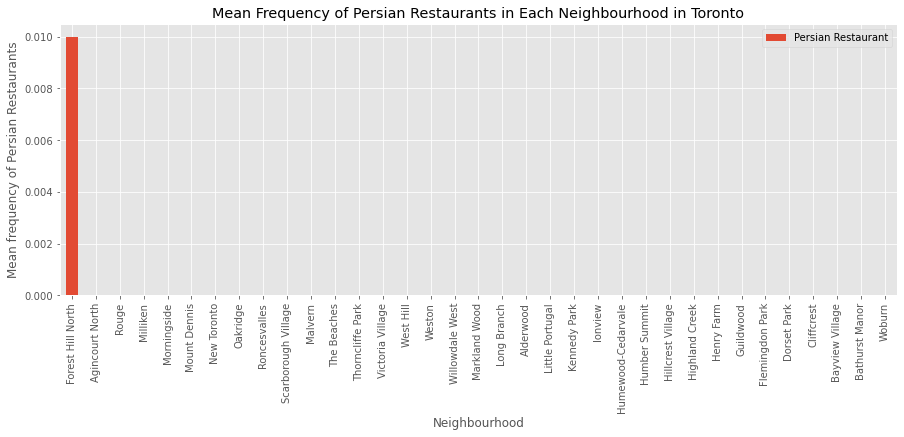

In [34]:
# sort by descending order
toronto_grouped.sort_values(by='Persian Restaurant', ascending=False, inplace=True)

mpl.style.use('ggplot')
toronto_grouped.plot(kind='bar', figsize=(15,5))

plt.title('Mean Frequency of Persian Restaurants in Each Neighbourhood in Toronto')
plt.xlabel('Neighbourhood')
plt.ylabel('Mean frequency of Persian Restaurants')

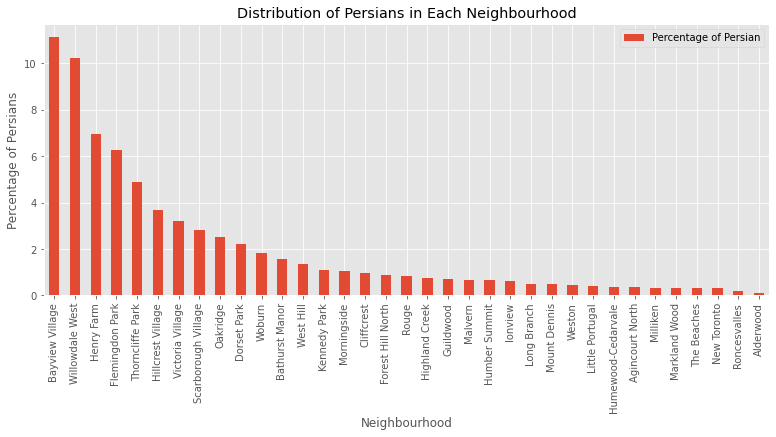

In [35]:
df_Persian_pop = df[['Neighbourhood', 'Percentage of Persian']].set_index('Neighbourhood')

# sort by descending order
df_Persian_pop.sort_values(by='Percentage of Persian', ascending=False, inplace=True)

#plot bar graph
df_Persian_pop.plot(kind='bar', figsize=(13,5))
plt.title('Distribution of Persians in Each Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Percentage of Persians')

plt.show()

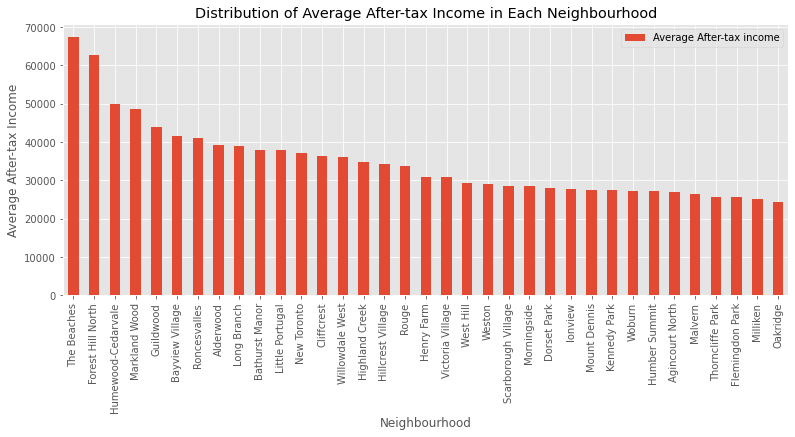

In [36]:
df_income = df[['Neighbourhood', 'Average After-tax income']].set_index('Neighbourhood')

# sort by descending order
df_income.sort_values(by='Average After-tax income', ascending=False, inplace=True)

#plot bar graph
df_income.plot(kind='bar', figsize=(13,5))
plt.title('Distribution of Average After-tax Income in Each Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Average After-tax Income')

plt.show()

In [37]:
# merge df with toronto_grouped
df_final = pd.merge(df, toronto_grouped, on='Neighbourhood')
df_final.head()

,Neighbourhood,Latitude,Longitude,Average After-tax income,Percentage of Persian,Persian Restaurant
0,Victoria Village,43.725882,-79.315572,30769.0,3.198172,0.0
1,Rouge,43.806686,-79.194353,33736.0,0.838782,0.0
2,Malvern,43.806686,-79.194353,26505.0,0.685025,0.0
3,Highland Creek,43.784535,-79.160497,34837.0,0.760365,0.0
4,Flemingdon Park,43.725900,-79.340923,25608.0,6.269092,0.0


In [38]:
from sklearn.preprocessing import StandardScaler
X = df_final.values[:,3:]
X = np.nan_to_num(X)
scal = StandardScaler()
df_final_normalized = scal.fit_transform(X)
df_final_normalized

array([[-4.03696216e-01,  4.31417747e-01, -1.71498585e-01],
       [-1.06506819e-01, -4.41618255e-01, -1.71498585e-01],
       [-8.30799548e-01, -4.98512160e-01, -1.71498585e-01],
       [ 3.77478756e-03, -4.70634534e-01, -1.71498585e-01],
       [-9.20647506e-01,  1.56773806e+00, -1.71498585e-01],
       [ 1.51506350e+00, -6.10315643e-01, -1.71498585e-01],
       [ 1.38094264e+00, -6.29278451e-01, -1.71498585e-01],
       [ 9.06361122e-01, -4.90803303e-01, -1.71498585e-01],
       [-6.31270975e-01, -3.70409955e-01, -1.71498585e-01],
       [-5.58751553e-01, -2.45418965e-01, -1.71498585e-01],
       [ 3.27446079e+00, -6.31890048e-01, -1.71498585e-01],
       [-7.47061653e-01, -7.05354055e-02, -1.71498585e-01],
       [-5.97297886e-02,  6.02777072e-01, -1.71498585e-01],
       [ 3.13284473e-01, -1.69197770e-01, -1.71498585e-01],
       [-9.13936454e-01,  1.06237940e+00, -1.71498585e-01],
       [-6.17548377e-01,  2.87906837e-01, -1.71498585e-01],
       [-3.87469494e-01,  1.82499036e+00

In [39]:
df_normalized = pd.DataFrame(df_final_normalized)
df_normalized.rename(columns={0:'Average After-tax income', 1:'Percentage of Persian', 2:'Persian Restaurant Mean Freq.'}, inplace=True)
df_normalized.head()

,Average After-tax income,Percentage of Persian,Persian Restaurant Mean Freq.
0,-0.403696,0.431418,-0.171499
1,-0.106507,-0.441618,-0.171499
2,-0.830800,-0.498512,-0.171499
3,0.003775,-0.470635,-0.171499
4,-0.920648,1.567738,-0.171499


In [40]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_normalized)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 0, 3, 0, 2, 0, 0, 0, 3, 3], dtype=int32)

In [41]:
# add clustering labels
df_normalized = pd.DataFrame(scal.inverse_transform(df_final_normalized))
df_normalized.rename(columns={0:'Average After-tax income', 1:'Percentage of Persian', 
                              2:'Persian Restaurant Mean Freq.'}, inplace=True)
df_normalized['Neighbourhood'] = df_final['Neighbourhood']
df_normalized.insert(0, 'Cluster Labels', kmeans.labels_)
df_merged = df

# merge df_normalized with df to add latitude/longitude for each neighborhood
df_merged = df_merged.merge(df_normalized, on='Neighbourhood', how='left')
cols_to_drop = ['Average After-tax income_y', 'Percentage of Persian_y']
df_merged.drop(columns = cols_to_drop, inplace = True)
df_merged.rename(columns = {'Average After-tax income_x': 'Average After-tax income',
                            'Percentage of Persian_x': 'Percentage of Persian'}, inplace = True)
df_merged.head() # check the last columns!

,Neighbourhood,Latitude,Longitude,Average After-tax income,Percentage of Persian,Cluster Labels,Persian Restaurant Mean Freq.
0,Victoria Village,43.725882,-79.315572,30769.0,3.198172,3,0.0
1,Rouge,43.806686,-79.194353,33736.0,0.838782,0,0.0
2,Malvern,43.806686,-79.194353,26505.0,0.685025,3,0.0
3,Highland Creek,43.784535,-79.160497,34837.0,0.760365,0,0.0
4,Flemingdon Park,43.725900,-79.340923,25608.0,6.269092,2,0.0


In [42]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Neighbourhood'], df_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [43]:
df_merged.loc[df_merged['Cluster Labels'] == 0].reset_index(drop = True)

,Neighbourhood,Latitude,Longitude,Average After-tax income,Percentage of Persian,Cluster Labels,Persian Restaurant Mean Freq.
0,Rouge,43.806686,-79.194353,33736.0,0.838782,0,0.0
1,Highland Creek,43.784535,-79.160497,34837.0,0.760365,0,0.0
2,Humewood-Cedarvale,43.693781,-79.428191,49925.0,0.382875,0,0.0
3,Markland Wood,43.643515,-79.577201,48586.0,0.331628,0,0.0
4,Guildwood,43.763573,-79.188711,43848.0,0.705859,0,0.0
5,Bathurst Manor,43.754328,-79.442259,37927.0,1.575002,0,0.0
6,Little Portugal,43.647927,-79.419750,37924.0,0.417765,0,0.0
7,Cliffcrest,43.716316,-79.239476,36364.0,0.972702,0,0.0
8,Roncesvalles,43.648960,-79.456325,40926.0,0.200347,0,0.0
9,New Toronto,43.605647,-79.501321,37209.0,0.305330,0,0.0


In [44]:
df_merged.loc[df_merged['Cluster Labels'] == 1].reset_index(drop = True)

,Neighbourhood,Latitude,Longitude,Average After-tax income,Percentage of Persian,Cluster Labels,Persian Restaurant Mean Freq.
0,Forest Hill North,43.696948,-79.411307,62714.0,0.858972,1,0.01


In [45]:
df_merged.loc[df_merged['Cluster Labels'] == 2].reset_index(drop = True)

,Neighbourhood,Latitude,Longitude,Average After-tax income,Percentage of Persian,Cluster Labels,Persian Restaurant Mean Freq.
0,Flemingdon Park,43.725900,-79.340923,25608.0,6.269092,2,0.0
1,Henry Farm,43.778517,-79.346556,30931.0,6.964320,2,0.0
2,Bayview Village,43.786947,-79.385975,41440.0,11.146943,2,0.0
3,Willowdale West,43.782736,-79.442259,36093.0,10.244450,2,0.0


In [46]:
df_merged.loc[df_merged['Cluster Labels'] == 3].reset_index(drop = True)

,Neighbourhood,Latitude,Longitude,Average After-tax income,Percentage of Persian,Cluster Labels,Persian Restaurant Mean Freq.
0,Victoria Village,43.725882,-79.315572,30769.0,3.198172,3,0.0
1,Malvern,43.806686,-79.194353,26505.0,0.685025,3,0.0
2,Morningside,43.763573,-79.188711,28497.0,1.031223,3,0.0
3,West Hill,43.763573,-79.188711,29221.0,1.369013,3,0.0
4,Woburn,43.770992,-79.216917,27341.0,1.841638,3,0.0
5,Hillcrest Village,43.803762,-79.363452,34203.0,3.661273,3,0.0
6,Thorncliffe Park,43.705369,-79.349372,25675.0,4.903354,3,0.0
7,Scarborough Village,43.744734,-79.239476,28634.0,2.810332,3,0.0
8,Ionview,43.727929,-79.262029,27852.0,0.623121,3,0.0
9,Kennedy Park,43.727929,-79.262029,27439.0,1.109619,3,0.0


In [47]:
df_merged.loc[df_merged['Cluster Labels'] == 4].reset_index(drop = True)

,Neighbourhood,Latitude,Longitude,Average After-tax income,Percentage of Persian,Cluster Labels,Persian Restaurant Mean Freq.
0,The Beaches,43.676357,-79.293031,67490.0,0.32457,4,0.0
